In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  

In [3]:
!python --version

Python 3.9.12


In [4]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    #çompute trip duration in minutes
    df["duration_in_mins"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration_in_mins = df.duration_in_mins.apply(lambda td: td.total_seconds()/60)

    #Select all trips less than 60
    df = df[(df.duration_in_mins>=1) & (df.duration_in_mins <=60)]

    #Extract the most useful categorical and numerical variables from our dataset
    categorical = ['PULocationID','DOLocationID']

    #Convert numerical variables to categorical variables
    df[categorical] = df[categorical].astype(str)
    
    return df

In [5]:
df_train = read_dataframe("./data/green_tripdata_2022-01.parquet")
df_val = read_dataframe("./data/green_tripdata_2022-02.parquet")
df_train.shape, df_val.shape

((59603, 21), (66097, 21))

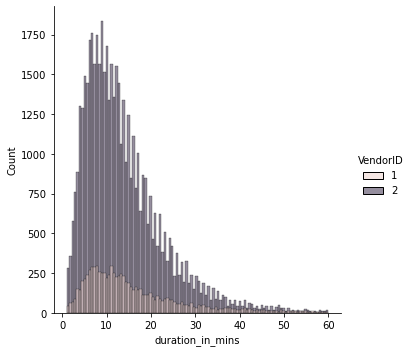

In [6]:
#Visualize trips less than 60
ldf = df_train
ldf = ldf[(ldf.duration_in_mins>=1) & (ldf.duration_in_mins <=60)]
sns.displot(data =  ldf, x = "duration_in_mins", hue="VendorID")

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
import pickle

In [8]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("ny-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='ny-taxi-experiment', tags={}>

In [9]:
#combine the pickup and drop off location ids 
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [10]:
#Extract the most useful categorical and numerical variables from our dataset
# categorical = ['PULocationID','DOLocationID']
categorical = ['PU_DO']
numerical = ['trip_distance']

#perform data vectorization
dv = DictVectorizer()

#print out the features
# print(len(dv.feature_names_))

#Convert our selected features to dictionaries for our vectorizers to work
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

#Convert our selected features to dictionaries for our vectorizers to work
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration_in_mins'
y_train = df_train[target].values
y_val = df_val[target].values

In [12]:
#Lasso regression
with mlflow.start_run():
    #set developer tag name
    mlflow.set_tag("developer", "David")
    mlflow.set_tag("model", "Lasso Regression")

    #specify training and validation data path
    mlflow.log_param("train-data-path", "./data/green_tripdata_2022-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2022-02.parquet")

    #log model parameter alpha
    alpha = 0.001
    mlflow.log_param("alpha", alpha)

    #train our model
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    #model prediction
    y_pred = lr.predict(X_train)


    #evaluate our model
    rmse = mean_squared_error(y_train, y_pred, squared=False)

    #log model metric 
    mlflow.log_metric("rmse", rmse)
    print(rmse)

6.926543641418329


In [19]:
# #Use Linear Regreassion as our baseline

# #train our model
# lr = LinearRegression()
# lr.fit(X_train, y_train)

# #model prediction
# y_pred = lr.predict(X_train)

# #evaluate our model
# mean_squared_error(y_train, y_pred, squared=False)



In [13]:
#Linear regression
with mlflow.start_run():
    #set developer tag name
    mlflow.set_tag("developer", "David")
    mlflow.set_tag("model", "Linear Regression")

    #specify training and validation data path
    mlflow.log_param("train-data-path", "./data/green_tripdata_2022-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2022-02.parquet")


    #train our model
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    #model prediction
    y_pred = lr.predict(X_train)


    #evaluate our model
    rmse = mean_squared_error(y_train, y_pred, squared=False)

    #log model metric 
    mlflow.log_metric("rmse", rmse)
    #save model for deployment

    with open('models/linear_reg.bin', 'wb') as m_out:
        pickle.dump((dv,lr), m_out)
    
    mlflow.log_artifact(local_path = "models/linear_reg.bin", artifact_path="models_pickle")

In [14]:
#Ridge regression

#train our model
lr = Ridge(alpha=0.0005)
lr.fit(X_train, y_train)

#model prediction
y_pred = lr.predict(X_train)

#evaluate our model
mean_squared_error(y_train, y_pred, squared=False)

9.43591924993184

### XGBoost

In [15]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


/home/ubuntu/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [16]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [17]:
def objective(params):

    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [23]:
# from math import exp
# exp( -2)

0.1353352832366127

In [ ]:
#Experimenting hyperparamter optimization library(hyperopt) to help us choose our model parameters for xgboost
#Will take a while to get enough data for us to make decisions

search_space = {
    'ma_depth': scope.int(hp.quniform('max_depth',4 , 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -1, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda':hp.loguniform('reg_lambda',-6, -1) ,
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest, 
    max_evals=50, #50 iterations
    trials=Trials()
)

In [22]:
#Parameter optimization using the best hyper parameters we got from hyperopt to retraining our model

with mlflow.start_run():
    best_params = {
        'ma_depth': 49,
        'learning_rate': 0.4197998879005521,
        'reg_alpha': 0.02765879156310126,
        'reg_lambda': 0.30675307751450226 ,
        'min_child_weight': 2.705518581285925,
        'objective': 'reg:linear',
        'seed': 42
    }

    #log model parameters
    mlflow.log_params(best_params)

    mlflow.xgboost.autolog(disable=True)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
    )
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    #log model artifacts
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[16:55:51] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[16:55:51] WARNING: ../src/learner.cc:576: 
Parameters: { "ma_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-rmse:11.58891
[1]	validation-rmse:8.61349
[2]	validation-rmse:7.21460
[3]	validation-rmse:6.60235
[4]	validation-rmse:6.32854
[5]	validation-rmse:6.19976
[6]	validation-rmse:6.14111
[7]	validation-rmse:6.10324
[8]	validation-rmse:6.08068
[9]	validation-rmse:6.07374
[10]	validation-rmse:6.06802
[11]	validation-rmse:6.06361
[12]	validation-rmse:6.05834
[13]	validation-rmse:6.05337
[14]	validation-rmse:6.04805
[15]	validation-rmse:6.04460
[16]	validation-rmse:6.04017
[17]	validation-rmse:6.03856
[18]	vali

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


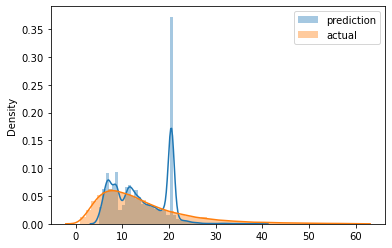

In [25]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [31]:
#TWO WAYS TO LOAD OUR MODEL FOR PREDICTION
#EITHER AS A PYTHON FUNCTION OR AN XGBOOST OBJECT

#Model URI
logged_model = 'runs:/d5b6e47f221a4604b500c00a2749eaae/models_mlflow'

# Load model as a python function
loaded_model = mlflow.pyfunc.load_model(logged_model)

#load model as an xgboost object giving us access to different methods
xgboost_model = mlflow.xgboost.load_model(logged_model)

print(loaded_model)
print(xgboost_model)


[17:07:52] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:52] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: d5b6e47f221a4604b500c00a2749eaae



In [33]:
#Making predictions with the model
y_pred = xgboost_model.predict(valid)
y_pred[:5]

array([ 6.6563406,  4.261284 , 26.016714 , 36.309708 , 27.7878   ],
      dtype=float32)

In [34]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

In [36]:
mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
